In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



In [4]:
train = pd.read_csv('../Pubg-predict/input/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('../Pubg-predict/input/test_V2.csv')
test = reduce_mem_usage(test)

print("Train : ",train.shape)
print("Test : ",test.shape)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 498.81 MB
Decreased by 49.3%
Memory usage of dataframe is 413.18 MB
Memory usage after optimization is: 225.31 MB
Decreased by 45.5%
Train :  (4446966, 29)
Test :  (1934174, 28)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 category
groupId            category
matchId            category
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          category
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: category(4), float16(6), int16(5), int8(14)
memory usage: 498.8 MB


In [6]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [11]:
# Stats
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4446966.00,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4446966.0,4.446966e+06,4.446966e+06,4446966.000,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,NaN,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,NaN,3.496091e-03,NaN,2.386841e-02,7.918208e-03,NaN,3.660488e+00,6.064601e+02,NaN
std,5.885731e-01,1.715794e+00,NaN,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,NaN,7.337297e-02,NaN,1.673935e-01,9.261157e-02,NaN,2.456544e+00,7.397004e+02,0.000000e+00
min,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,155.125,2.000000e+00,0.000000e+00,1.999512e-01
50%,0.000000e+00,0.000000e+00,84.25,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,685.500,3.000000e+00,0.000000e+00,4.582520e-01
75%,0.000000e+00,2.000000e+00,186.00,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.910095e-01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1976.000,5.000000e+00,1.495000e+03,7.407227e-01
max,2.200000e+01,3.300000e+01,6616.00,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.070400e+04,1.800000e+01,3824.0,1.200000e+01,5.000000e+00,25776.000,2.360000e+02,2.013000e+03,1.000000e+00


In [18]:
# Check row with NaN value
display(train[train.isnull().any(1)])
display(test[test.isnull().any(1)])

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints


In [19]:
# Drop row with NaN 'winPlacePerc' value
train.drop(2744604, inplace=True)

KeyError: 'labels [2744604] not contained in axis'

In [21]:
# The row at index 2744604 will be gone
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined


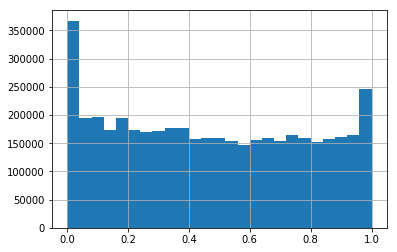

In [22]:
train['winPlacePerc'].hist(bins=25);

In [23]:
def featStat(featureName, constrain,plotType):
    feat = train[featureName][train[featureName]>0]
    data = train[[featureName,'winPlacePerc']].copy()
    q99 = int(data[featureName].quantile(0.99))
    plt.rcParams['figure.figsize'] = 15,5;   
    
    if constrain!=None:
        feat = feat[feat<constrain]
    if plotType == 'hist':
        plt.subplot(1,2,1)
        feat.hist(bins=50);
        plt.title(featureName);
        
        n = 20
        cut_range = np.linspace(0,q99,n)
        cut_range = np.append(cut_range, data[featureName].max())
        data[featureName] = pd.cut(data[featureName],
                                         cut_range,
                                         labels=["{:.0f}-{:.0f}".format(a_, b_) for a_, b_ in zip(cut_range[:n], cut_range[1:])],
                                         include_lowest=True
                                        )
        ax = plt.subplot(1,2,2)
        sns.boxplot(x="winPlacePerc", y=featureName, data=data, ax=ax, color="#2196F3")
        ax.set_xlabel('winPlacePerc', size=14, color="#263238")
        ax.set_ylabel(featureName, size=14, color="#263238")
        plt.gca().xaxis.grid(True)
        plt.tight_layout()
           
    if plotType == 'count':        
        plt.subplot(1,2,1)
        sns.countplot(feat, color="#2196F3");
        
        plt.subplot(1,2,2)
        data.loc[data[featureName] > q99, featureName] = q99+1
        x_order = data.groupby(featureName).mean().reset_index()[featureName]
        x_order.iloc[-1] = str(q99+1)+"+"
        data[featureName][data[featureName] == q99+1] = str(q99+1)+"+"
        
        ax = sns.boxplot(x=featureName, y='winPlacePerc', data=data, color="#2196F3", order = x_order);
        ax.set_xlabel(featureName, size=14, color="#263238")
        ax.set_ylabel('WinPlacePerc', size=14, color="#263238")
    plt.tight_layout()

C:\Users\chosun\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


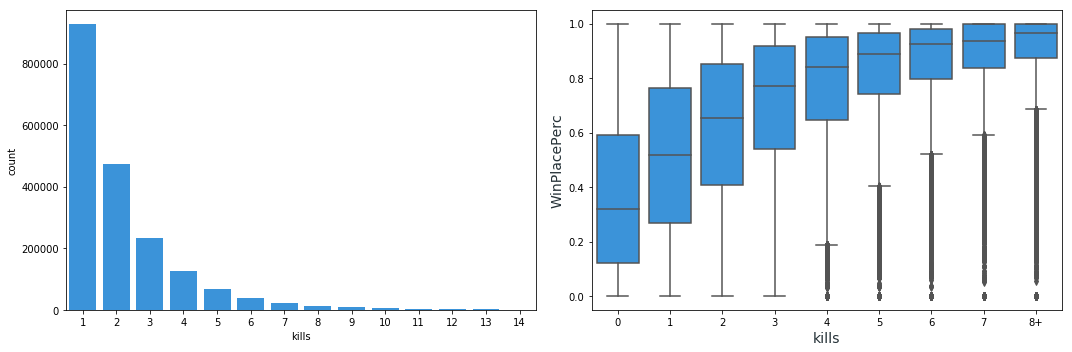

In [26]:
featStat('kills',15,'count');
plt.show();

In [28]:
# Create feature totalDistance
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

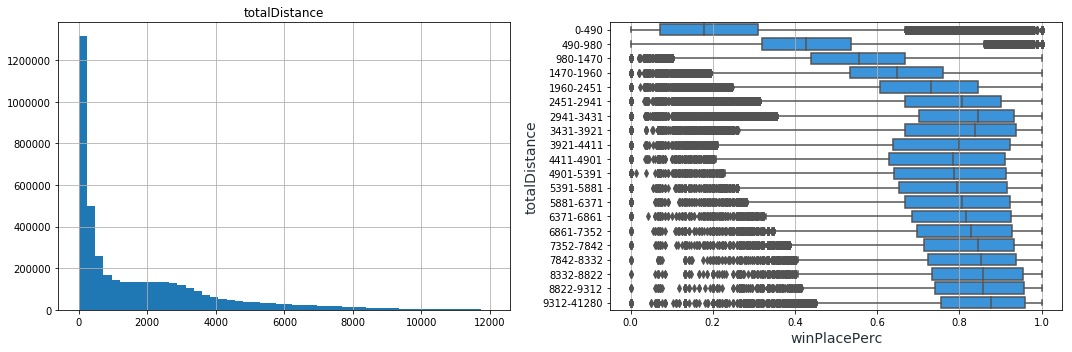

In [32]:
featStat('totalDistance',12000,'hist')
plt.show()

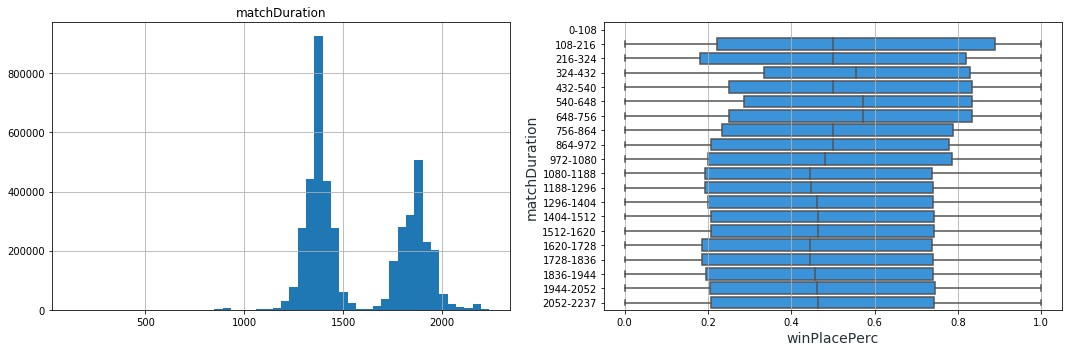

In [33]:
featStat('matchDuration',2500,'hist')
plt.show()